In [1]:
from collections import defaultdict
import json
from tqdm import tqdm
import wptools
import re
from collections import defaultdict

In [2]:
def parse_occupations(text):
    """Extracts multiple occupations from complex formatted strings."""
    # Handle {{hlist|...}} and {{flatlist|...}}
    if '{{' in text:
        text = re.sub(r'\[\[([^\]]+)\]\]', r'\1', text)  # Simplify links
        text = re.sub(r'{{[^|]*\|', '', text)  # Remove the template up to the first '|'
        text = re.sub(r'}}', '', text)  # Remove closing braces
    # Handle <br> tags and strip unwanted characters
    text = re.sub(r'<br\s*/?>', '|', text)  # Replace <br> with |
    
    # Remove additional unwanted characters
    text = re.sub(r'\[\[|\]\]', '', text)  # Remove double brackets
    text = re.sub(r'\* ', '', text)  # Remove asterisks with spaces

    # Split by '|' and new lines as well as commas now
    occupations = re.split(r'\||\n|,', text)
    return [occupation.strip("*").strip().lower() for occupation in occupations if occupation.strip()]


def get_occupation_from_wikipedia(entity):
    """Use wptools to fetch and parse the occupation from Wikipedia without verbose output."""
    try:
        page = wptools.page(entity, silent=True).get_parse(show=False)
        infobox = page.data['infobox']
        if 'occupation' in infobox:
            return parse_occupations(infobox['occupation'])
        else:
            return ["Occupation not listed"]
    except Exception as e:
        return [f"Error retrieving page: {str(e)}"]

In [3]:
def process_entities(all_data, top_ten):
    """Process entities to create occupation groups and counts"""
    occupation_count = defaultdict(int)
    group_occupations = defaultdict(dict)  # {occupation: {entity: summary}}
    
    for entry in tqdm(all_data, desc="Processing entities"):
        entity = entry['topic'].strip()
        summary = entry['summary']
        
        # Get occupations from Wikipedia
        occupations = get_occupation_from_wikipedia(entity)
        
        # Filter valid occupations
        valid_occupations = [
            occ.lower() for occ in occupations
            if "error" not in occ.lower() 
            and "not listed" not in occ.lower()
        ]
        
        # Update counts and groups
        for occ in valid_occupations:
            if occ in top_ten:
                occupation_count[occ] += 1
                group_occupations[occ][entity] = summary
    
    return occupation_count, group_occupations

In [4]:
def load_data_from_jsonl(jsonl_files):
    data = []
    for file_path in jsonl_files:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Each line is a complete JSON object
                entry = json.loads(line)
                data.append(entry)
    return data

# Assuming you have paths to your JSONL files
labled_path = 'data/labeled/'
jsonl_files = [labled_path+'ChatGPT.jsonl', labled_path+'InstructGPT.jsonl', labled_path+'PerplexityAI.jsonl']
all_data = load_data_from_jsonl(jsonl_files)
labeld_data = [{'topic': i['topic'],'summary':i['output']} for i in all_data]

In [5]:
import json
from pathlib import Path

def load_data_from_jsonl(jsonl_files):
    data = []
    for file_path in jsonl_files:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                # Each line is a complete JSON object
                entry = json.loads(line)
                data.append(entry)
    return data

unlabeled_path = Path('data/unlabeled')
labeled_path = Path('data/labeled')
jsonl_files = list(unlabeled_path.glob('*.jsonl'))+list(labeled_path.glob('*.jsonl'))######
all_data = load_data_from_jsonl(jsonl_files)
unlabeld_data = [{'topic': i['topic'],'summary':i['output']} for i in all_data]


In [6]:
all_data = labeld_data +unlabeld_data

In [7]:
len(all_data)

7098

In [9]:
top_ten = ["actor", "actress", "singer", "producer", "musician", "director", "writer", "songwriter", "politician", "author"]
occupation_count, group_occupations = process_entities(all_data, top_ten)

Processing entities:   0%|          | 0/7098 [00:00<?, ?it/s]

Processing entities: 100%|██████████| 7098/7098 [40:19<00:00,  2.93it/s]


In [11]:
occupation_count

defaultdict(int,
            {'actor': 708,
             'actress': 540,
             'singer': 486,
             'author': 126,
             'writer': 174,
             'politician': 168,
             'songwriter': 330,
             'producer': 228,
             'musician': 192,
             'director': 60})

In [10]:
with open("output/top_ten/gen_summaries_all.json", "w") as f:
    json.dump(group_occupations, f, indent=2, ensure_ascii=False)

In [2]:
with open("output/top_ten/gen_summaries_all.json", "r", encoding="utf-8") as f:
    group_occupations = json.load(f)

In [3]:
group_occupations.keys()

dict_keys(['actor', 'actress', 'singer', 'author', 'writer', 'politician', 'songwriter', 'producer', 'musician', 'director'])

In [4]:
import os
import json
import re
from collections import defaultdict, Counter
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/yc833/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yc833/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yc833/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
from utils import preprocess_text, get_feature_probabilities
from utils import save_feature_probs, save_all_matrices

In [8]:
with open("output/top_ten/gen_summaries_all.json", "r") as f:
    group_occupations = json.load(f)

In [9]:
group_occupations.keys()

dict_keys(['actor', 'actress', 'singer', 'author', 'writer', 'politician', 'songwriter', 'producer', 'musician', 'director'])

In [10]:
group_occupations["actor"]["Lanny Flaherty"]

"Lanny Flaherty is an American actor born on July 27, 1942, in Pontotoc, Mississippi[1]. He attended the University of Southern Mississippi after high school[1]. Flaherty has been active in the film industry since 1984 and has given memorable performances in movies such as Lonesome Dove, Natural Born Killers, Book of Shadows: Blair Witch 2, Signs, Winter People, Miller's Crossing, Blood In Blood Out, Tom and Huck and Home Fries[1][2][4][5]. He has also appeared in several television shows including The Equalizer, New York News and White Collar as well as a two-episode stint on The Education of Max Bickford as Whammo[1].\n\nIn Winter People (1989), Flaherty played the role of Gudger Wright[2]. In Where the Truth Lies (2005), he played the role of Lanny Morris alongside Kevin Bacon and Colin Firth[3]. In All Good Things (2010), he played the role of a landlord alongside Ryan Gosling and Kirsten Dunst[5].\n\nFlaherty resides in New York City[1]."

In [11]:
feature_probs, all_matrices = get_feature_probabilities(group_occupations)
save_feature_probs(feature_probs, "output/top_ten/feature_probabilities_gen_2.json")
save_all_matrices(all_matrices, "output/top_ten/all_matrices_gen_2.json")

Processing occupations:   0%|          | 0/10 [00:00<?, ?it/s]

Processing occupations: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


In [38]:
# # both f_1|occ and matrices
# feature_probs, all_matrices = get_feature_probabilities(group_occupations)
# with open("output/top_ten/feature_probabilities_gen.json", "w") as f:
#     json.dump(feature_probs, f, indent=2, ensure_ascii=False)

In [12]:
feature_probs.keys()

dict_keys(['actor', 'actress', 'singer', 'author', 'writer', 'politician', 'songwriter', 'producer', 'musician', 'director'])

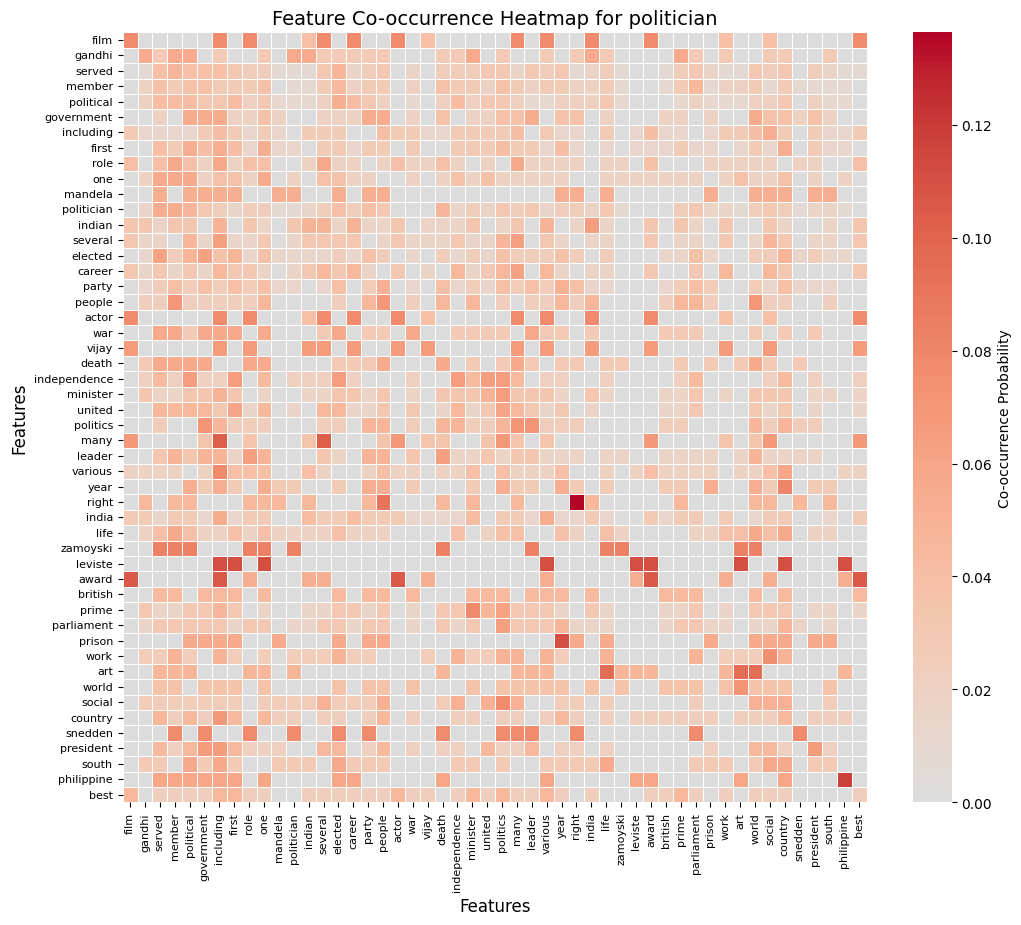

In [13]:
from utils import plot_heatmap
occupation = 'politician'
data_for_occupation = all_matrices[occupation] 
plot_heatmap(data_for_occupation, occupation)


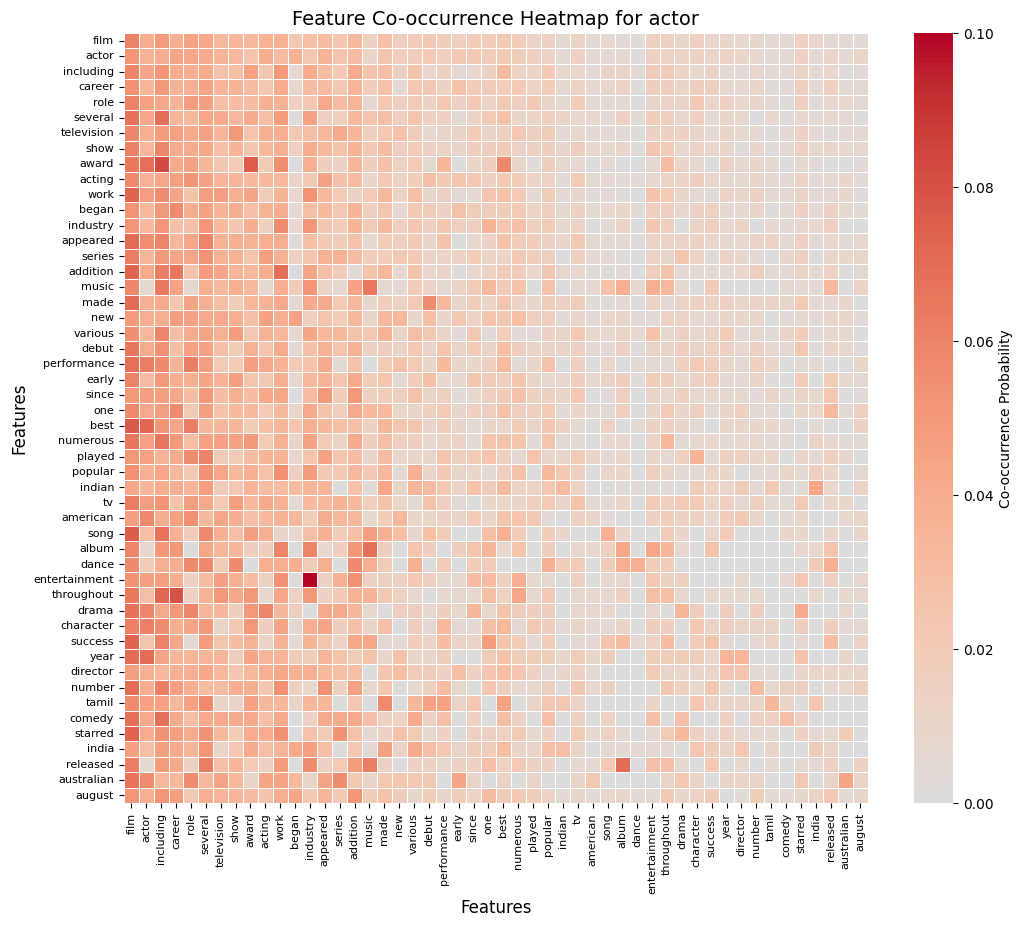

In [14]:
occupation = 'actor'
data_for_occupation = all_matrices[occupation] 
plot_heatmap(data_for_occupation, occupation)
